In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge

**Будем работать с набором данных по ценам на дома в Бостоне (репозиторий UCI).**
**Загружаем данные.**

In [2]:
boston = load_boston()
X, y = boston['data'], boston['target']

**Признаки:**
- CRIM - количество преступлений на душу населения
- ZN - процент жилых участков площадью больше 25 тыс. кв. футов (~ 23 сотки)
- INDUS - процент площадей под оптовую торговлю 
- CHAS - протекает ли река
- NOX - концентрация оксидов азота
- RM - среднее число комнат в здании
- AGE - доля зданий, построенных до 1940 года 
- DIS - взвешенное расстояние до 5 деловых центров Бостона
- RAD - индекс доступности скоростных магистралей
- TAX - уровень налогов
- PTRATIO - среднее число учащихся на одного преподавателя 
- B - процент афроамериканцев
- LSTAT - процент граждан с низким уровнем жизни
- MEDV (целевой) - медианная стоимости домов в районе

In [3]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

**Посмотрим на первые 2 записи.**

In [4]:
X[:2]

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00]])

## Lasso-регрессия

Lasso-регрессия решает задачу минимизации среднеквардатичной ошибки с L1-регуляризацией:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d |w_i|$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

**Обучите 2 Lasso-регрессии, с коэффициентами $\alpha$={0.1, 10} .** 

In [5]:
lasso1 = Lasso(alpha=0.1).fit(X, y)
lasso2 = Lasso(alpha=10).fit(X, y)

**1 Вопрос**: При каких признаках коэффициенты обнулились в каждом из случаев?

In [6]:
pd.DataFrame((lasso1.coef_, lasso2.coef_), columns=boston.feature_names, index=(1, 2))

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
1,-0.097894,0.049211,-0.036619,0.95519,-0.0,3.703202,-0.010037,-1.160538,0.274707,-0.014570,-0.770654,0.010249,-0.568769
2,-0.000000,0.026146,-0.000000,0.00000,0.0,0.000000,0.000000,-0.000000,0.000000,-0.009282,-0.000000,0.007496,-0.564038


Коэффициенты обнулились при признаке NOX

**Теперь обучите Lasso-регрессию для 200 разных $\alpha$ в интервале [0.1,10] ** 

In [7]:
n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)
model = Lasso()

coefs = []
for a in alphas:
    coefs.append(Lasso(alpha=a).fit(X, y).coef_)

**Визуализируем динамику весов при увеличении параметра регуляризации:**

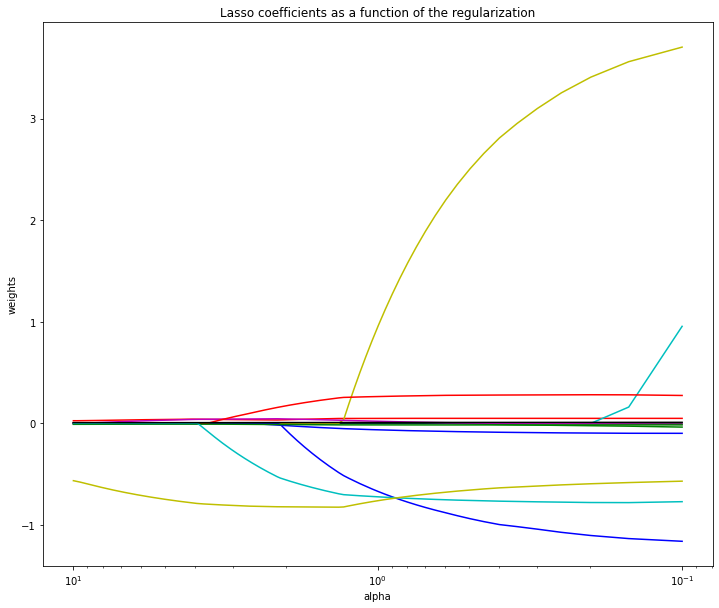

In [8]:
plt.figure(figsize=(12, 10))
ax = plt.gca()
ax.set_prop_cycle(cycler('color', ['b', 'r', 'g', 'c', 'k', 'y', 'm']))

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) #reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

**Видим что чем больше alpha (справа налево), тем больше признаков(разноцветные линии) зануляется**

**Теперь найдите лучшее значение $\alpha$ с помощью кросс-валидации LassoCV.**

In [9]:
lasso_cv = LassoCV(alphas=alphas).fit(X, y)
lasso_cv.alpha_

0.3487437185929648

**Метод `cross_val_score` из sklearn максимизирует метрику качества (поэтому вместо 
минимизации MSE сделаем максимизацию отрицательного MSE – `neg_mean_squared_error`) для модели с найденным оптимальным  alpha**

In [10]:
scores = cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=3, scoring='neg_mean_squared_error')
scores

array([-17.47718984, -46.06533633, -71.8921433 ])

**Чтобы все-таки трактовать результат в терминах обычного MSE, посчитайте модуль среднего значения метрики `neg_mean_squared_error` на кросс-валидации.**

In [11]:
abs(scores.mean())

45.14488982155845

**Замечание: LassoCV сортирует значения параметров по убыванию – так проще оптимизировать. Из-за этого может показаться, что оптимизация параметра $\alpha$ работает неправильно**

In [12]:
lasso_cv.alphas[:10] # значения параметров на входе

array([0.1       , 0.14974874, 0.19949749, 0.24924623, 0.29899497,
       0.34874372, 0.39849246, 0.44824121, 0.49798995, 0.54773869])

In [13]:
lasso_cv.alphas_[:10] # преобразованные значения параметров

array([10.        ,  9.95025126,  9.90050251,  9.85075377,  9.80100503,
        9.75125628,  9.70150754,  9.65175879,  9.60201005,  9.55226131])

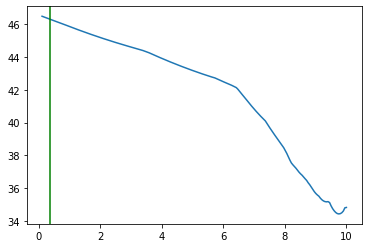

In [14]:
plt.plot(lasso_cv.alphas, lasso_cv.mse_path_.mean(1)) # неверно
plt.axvline(lasso_cv.alpha_, c='g');

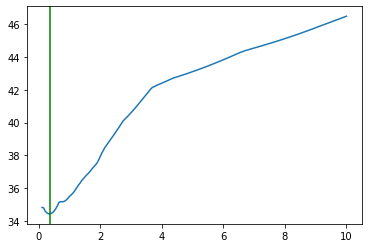

In [15]:
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(1)) # верно
plt.axvline(lasso_cv.alpha_, c='g');

 алгоритм так устроен, что запускает альфа в обратном порядке, поэтому и для вывода надо получать их в обратном порядке
 
 нижний график построен правильно, т.к. альфа бралась от лассо, а он сам всё преобразовывает. при альфа около 0, там самая маленькая ошибка

## Ridge-регрессия

Ridge-регрессия (или гребневая регрессия) решает задачу минимизации среднеквардатичной ошибки с L2-регуляризацией:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d w_i^2$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

В sklearn реализован специальный класс [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) для кросс-валидации с Ridge-регрессией.

In [16]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

**Обучите RidgeCV для разных альфа из ridge_alphas c метрикой качества 'neg_mean_squared_error'. Выведите веса признаков, есть ли среди них нулевые?** 

In [17]:
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='neg_mean_squared_error', store_cv_values=True).fit(X, y)
pd.DataFrame(ridge_cv.coef_.reshape(1, 13), columns=boston.feature_names)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.107807,0.046478,0.018825,2.680493,-17.35533,3.813088,0.000326,-1.469507,0.305084,-0.012367,-0.948187,0.009333,-0.525214


Нулевых весов нет

In [18]:
ridge_cv.cv_values_.transpose().shape

(200, 506)

**По аналогии с Lasso-регрессией визуализируйте для Ridge регрессии динамику весов при увеличении ridge_alphas**

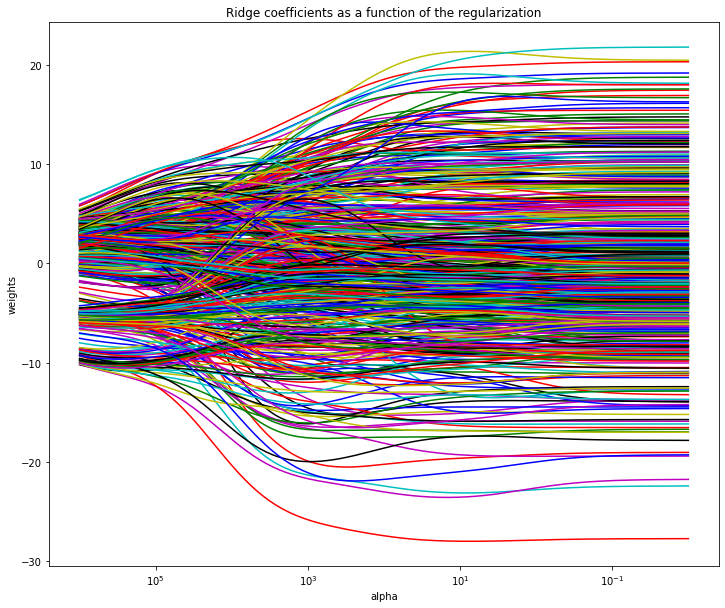

In [19]:
plt.figure(figsize=(12, 10))
ax = plt.gca()
ax.set_prop_cycle(cycler('color', ['b', 'r', 'g', 'c', 'k', 'y', 'm']))

ax.plot(ridge_alphas, ridge_cv.cv_values_.transpose())
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) #reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

тут надо было не ridge_cv выводить, а обычный ridge, с параметрами из ridge_cv

## Ссылки
- [Обощеннные линейные модели](http://scikit-learn.org/stable/modules/linear_model.html) (Generalized Linear Models, GLM) в Scikit-learn
- [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression), [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso), [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV), [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) и [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) в Scikit-learn
- [Статья](https://habrahabr.ru/post/264915/) "Методы отбора фич" на Хабрахабре с упоминанием Lasso-регрессии 